# Non-machine learning approach

Use product, client, agency, and sales channel ID, along with route information to predict demand based on mean averages for those values.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, datetime

from multiprocessing import Pool, cpu_count

%matplotlib inline

dataurl = '/home/dbricare/Documents/Python/datasets/bimbo/'

/usr/local/lib/python3.5/dist-packages/matplotlib/backends/backend_gtk3agg.py:18: UserWarning: The Gtk3Agg backend is known to not work on Python 3.x with pycairo. Try installing cairocffi.
  "The Gtk3Agg backend is known to not work on Python 3.x with pycairo. "


In [2]:
def inspectdata(testortrain, cols=None, rows=None):
    dataparams = {'sep':',', 'compression':'zip', 'usecols':cols, 'nrows':rows}
    df = pd.read_csv(dataurl+testortrain+'.csv.zip', **dataparams)
    print(df.shape)
    dictcols = dict(zip(list(df.columns),[df[col].dtype for col in df.columns]))
    print(dictcols)
    return df

# Load training data

In [3]:
usecols = ['Agencia_ID', 'Canal_ID', 'Ruta_SAK', 'Cliente_ID', 'Producto_ID', 
                                    'Demanda_uni_equil']

dftrain = None  # clear memory
dftrain = inspectdata('train', cols=usecols)
dftrain.head()

(74180464, 6)
{'Agencia_ID': dtype('int64'), 'Cliente_ID': dtype('int64'), 'Ruta_SAK': dtype('int64'), 'Producto_ID': dtype('int64'), 'Canal_ID': dtype('int64'), 'Demanda_uni_equil': dtype('int64')}


,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil
0,1110,7,3301,15766,1212,3
1,1110,7,3301,15766,1216,4
2,1110,7,3301,15766,1238,4
3,1110,7,3301,15766,1240,4
4,1110,7,3301,15766,1242,3


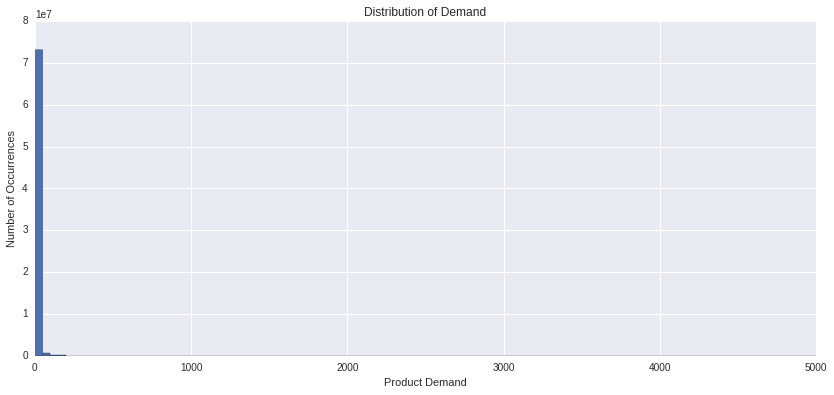

In [12]:
# distribution of values

_ = plt.figure(figsize=(14,6))
_ = plt.title('Distribution of Demand')
_ = plt.xlabel('Product Demand')
_ = plt.ylabel('Number of Occurrences')
# _ = plt.xlim(0,5000)

_ = dftrain['Demanda_uni_equil'].hist(bins=100)

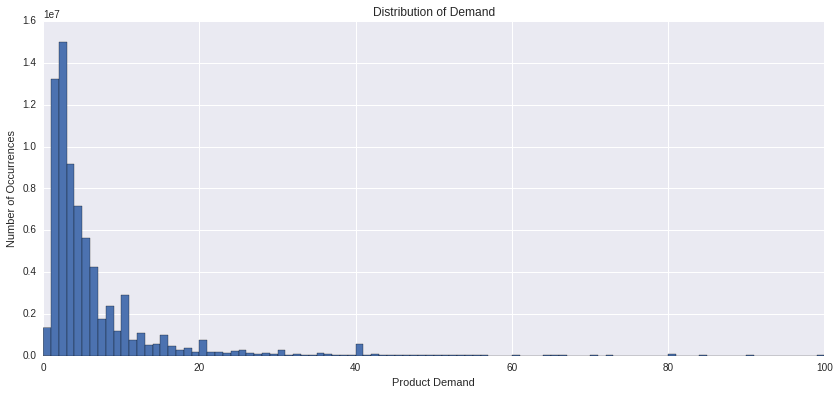

In [13]:
# finer grain distribution

_ = plt.figure(figsize=(14,6))
_ = plt.title('Distribution of Demand')
_ = plt.xlabel('Product Demand')
_ = plt.ylabel('Number of Occurrences')
_ = plt.xlim(0,100)

_ = dftrain['Demanda_uni_equil'][dftrain['Demanda_uni_equil']<=100].hist(bins=100)

In [22]:
# global statistics for demand

stats = dftrain['Demanda_uni_equil'].describe()
globalmean = stats.loc['mean']
stats

count    7.418046e+07
mean     7.224564e+00
std      2.177119e+01
min      0.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      6.000000e+00
max      5.000000e+03
Name: Demanda_uni_equil, dtype: float64

In [7]:
# most common value

print('Most common weekly demand value:', dftrain['Demanda_uni_equil'].mode().values[0])

Most common weekly demand value: 2


## Calculate 5-key group mean averages of `Demanda_uni_equil`

In [14]:
dffive = dftrain.groupby(['Agencia_ID', 'Canal_ID', 'Ruta_SAK', 'Cliente_ID', 'Producto_ID']).Demanda_uni_equil.mean()
dffive = dffive.reset_index(drop=False)
print(dffive.shape)
dffive.head()

(26396648, 6)


,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil
0,1110,7,3301,15766,325,1.000000
1,1110,7,3301,15766,328,1.000000
2,1110,7,3301,15766,1212,3.400000
3,1110,7,3301,15766,1216,2.833333
4,1110,7,3301,15766,1220,2.000000


# Load test data

In [4]:
# testiter = pd.read_csv(dataurl+'test.csv.zip', sep=',', compression='zip', chunksize=1000000, usecols=rawcols[:-1])

testcols = usecols[:-1].copy()
testcols.insert(0, 'id')

dftest = inspectdata('test', cols=testcols)
dftest.head()

(6999251, 6)
{'Agencia_ID': dtype('int64'), 'Cliente_ID': dtype('int64'), 'Ruta_SAK': dtype('int64'), 'Producto_ID': dtype('int64'), 'Canal_ID': dtype('int64'), 'id': dtype('int64')}


,id,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID
0,0,4037,1,2209,4639078,35305
1,1,2237,1,1226,4705135,1238
2,2,2045,1,2831,4549769,32940
3,3,1227,1,4448,4717855,43066
4,4,1219,1,1130,966351,1277


## Join test data with mean averages for 5-key group

Fill in `NaN` values with the most commonly occurring demand value.

In [15]:
dfjoin = pd.merge(dftest, dffive, how='left', on=usecols[:-1])

dfjoin.head()

,id,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil
0,0,4037,1,2209,4639078,35305,4.0
1,1,2237,1,1226,4705135,1238,NaN
2,2,2045,1,2831,4549769,32940,2.0
3,3,1227,1,4448,4717855,43066,NaN
4,4,1219,1,1130,966351,1277,NaN


In [16]:
# save the non-null Demand entries to disk for quick loading in the future

dfjoin[['id', 'Demanda_uni_equil']][dfjoin['Demanda_uni_equil'].notnull()].to_csv(
    dataurl+'5keyresults.csv', sep=',', index=False)

In [17]:
# also save the full dataframe null values to disk

dfjoin[dfjoin['Demanda_uni_equil'].isnull()].to_csv(dataurl+'5keynull.csv', sep=',', index=False)

In [26]:
# check number of NaN values and fill in with most common demand value (demand=2)

nas = dfjoin['Demanda_uni_equil'].isnull().sum()
print('Number of new products is {0:} out of {1:}'.format(nas, len(dfjoin)))
dfjoin['Demanda_uni_equil'].fillna(2, inplace=True)

dfjoin.head()

Number of new products is 1446543 out of 6999251


,id,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil
0,0,4037,1,2209,4639078,35305,4.0
1,1,2237,1,1226,4705135,1238,2.0
2,2,2045,1,2831,4549769,32940,2.0
3,3,1227,1,4448,4717855,43066,2.0
4,4,1219,1,1130,966351,1277,2.0


In [28]:
def mloutput(df, dataurl=dataurl):
    # save prediction
    import datetime
    nowtime = datetime.datetime.now()
    nowstr = nowtime.strftime('%Y%m%d_%H%M')
    df.to_csv(dataurl+'mloutput'+nowstr+'.csv', sep=',', index=False)
    return

In [29]:
mloutput(dfjoin[['id','Demanda_uni_equil']])

### Leaderboard result: 0.53532 RMSLE

## Repeat with improved NA filling

There are a lot of missing demand values in the test set, about 1 in 7 don't appear in the training data. It would be useful to find a better estimate for these new products. Perhaps by dropping the product ID from the grouping.

In [12]:
# how many test product IDs are missing from the training set? how much of the dataset is this?

sermiss = pd.Series(np.intersect1d(dftest['Producto_ID'].values, dftrain['Producto_ID'].values))
misscount = len(dftest['Producto_ID'].unique()) - len(sermiss.unique())
valcounts = dftest['Producto_ID'].value_counts(sort=False).to_dict()
total = len(dftest) - sum([valcounts[prod] for prod in sermiss.unique()])

print('{0:,} new product IDs out of {1:,} total product IDs'.format(misscount, len(dftest['Producto_ID'].unique())))
print('{0:,} new product occurrences out of {1:,} total records'.format(total,len(dftest)))

34 new product IDs out of 1,522 total product IDs
25,640 new product occurrences out of 6,999,251 total records


There are almost 1 million products that could not be identified by the 5-part key and only 25000 of those are due to new products. 

The other missing values are likely due to a new combination of agency, channel, route and client for products that do exist in the training data.

This it makes more sense to try provide a prediction for products based on these combinations rather than assuming all missing values are due to new products.

**New strategy:**

For missing values, make prediction based on mean for that specific product-client pair.